# Sign language classification
This is an attempt to create (apply) Xception model into sign language classification. The model was modified using this link: https://viblo.asia/p/paper-reading-xception-phien-ban-nang-cap-cua-inception-v3-MkNLr1ZoJgA 

Initial model was trained using a pretrained model. However, I believe for my task it is completely unnecessary to use a pretrained model. Instead, I modified the model by adding an output layer (which reduces the test loss) and input the MNIST dataset. 

The code down here are also modified version of the code T.A Doan The Vinh sent to me to practice training a model.

All training are done beforehand, and the checkpoint (finalXception.pth) is the best one compared to other checkpoints. If you are not interested in re-train the model then move to infer.py

Thank you!

In [112]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np # for numerical operations
import pandas as pd
import matplotlib.pyplot as plt # for plotting
import random # no longer needed
import time

import torch # model building
import torch.optim as optim
import os
import wandb # for logging
from torch import nn # for neural network layers
import torch.nn.functional as F # for neural network functional operations
from torch.utils.data import Dataset # for creating custom dataset
from torch.utils.data import DataLoader # for creating data loader
# from torchvision import datasets # for common datasets
from torchvision.transforms import ToTensor # for data transformation

from torchsummary import summary

In [113]:
# This is no longer needed
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [114]:
# This is no longer needed
# for dirname, _, filenames in os.walk('/content/drive/MyDrive/ColabNotebooks/data'):
#     for filename in filenames:
#         print(os.path.join(dirname,filename))

/content/drive/MyDrive/ColabNotebooks/data/sign_mnist_train.csv
/content/drive/MyDrive/ColabNotebooks/data/sign_mnist_test.csv
/content/drive/MyDrive/ColabNotebooks/data/myXception.pth
/content/drive/MyDrive/ColabNotebooks/data/xception-43020ad28.pth
/content/drive/MyDrive/ColabNotebooks/data/finalXception.pth
/content/drive/MyDrive/ColabNotebooks/data/wandb/debug.log
/content/drive/MyDrive/ColabNotebooks/data/wandb/debug-internal.log
/content/drive/MyDrive/ColabNotebooks/data/wandb/run-20241207_065855-z1sfgtku/run-z1sfgtku.wandb
/content/drive/MyDrive/ColabNotebooks/data/wandb/run-20241207_065855-z1sfgtku/logs/debug.log
/content/drive/MyDrive/ColabNotebooks/data/wandb/run-20241207_065855-z1sfgtku/logs/debug-core.log
/content/drive/MyDrive/ColabNotebooks/data/wandb/run-20241207_065855-z1sfgtku/logs/debug-internal.log
/content/drive/MyDrive/ColabNotebooks/data/wandb/run-20241207_065855-z1sfgtku/files/wandb-metadata.json
/content/drive/MyDrive/ColabNotebooks/data/wandb/run-20241207_06585

In [115]:
# This is no longer needed
# %cd /content/drive/MyDrive/ColabNotebooks/data

/content/drive/MyDrive/ColabNotebooks/data


In [116]:
train_data = pd.read_csv("sign_mnist_train.csv")
test_data = pd.read_csv("sign_mnist_test.csv")

train_data

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93


In [118]:
(x_train, y_train) = train_data.drop(labels = 'label', axis = 1), train_data['label']
(x_test, y_test) = test_data.drop(labels = 'label', axis = 1), test_data['label']
print('Training image: ', x_train.shape)
print('Training label: ', y_train.shape)

Training image:  (27455, 784)
Training label:  (27455,)


In [119]:
x_train

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,107,118,127,134,139,143,146,150,153,156,...,207,207,207,207,206,206,206,204,203,202
1,155,157,156,156,156,157,156,158,158,157,...,69,149,128,87,94,163,175,103,135,149
2,187,188,188,187,187,186,187,188,187,186,...,202,201,200,199,198,199,198,195,194,195
3,211,211,212,212,211,210,211,210,210,211,...,235,234,233,231,230,226,225,222,229,163
4,164,167,170,172,176,179,180,184,185,186,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,189,189,190,190,192,193,193,193,193,194,...,132,165,99,77,52,200,234,200,222,225
27451,151,154,157,158,160,161,163,164,166,167,...,198,198,198,198,198,196,195,195,195,194
27452,174,174,174,174,174,175,175,174,173,173,...,121,196,209,208,206,204,203,202,200,200
27453,177,181,184,185,187,189,190,191,191,190,...,119,56,27,58,102,79,47,64,87,93


In [120]:
y_train

,label
0,3
1,6
2,2
3,2
4,13
...,...
27450,13
27451,23
27452,18
27453,17


In [121]:
 # Normalizing
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train = x_train.values.reshape(-1,28,28,1)
x_test = x_test.values.reshape(-1,28,28,1)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(27455, 28, 28, 1)
(7172, 28, 28, 1)
(27455,)
(7172,)


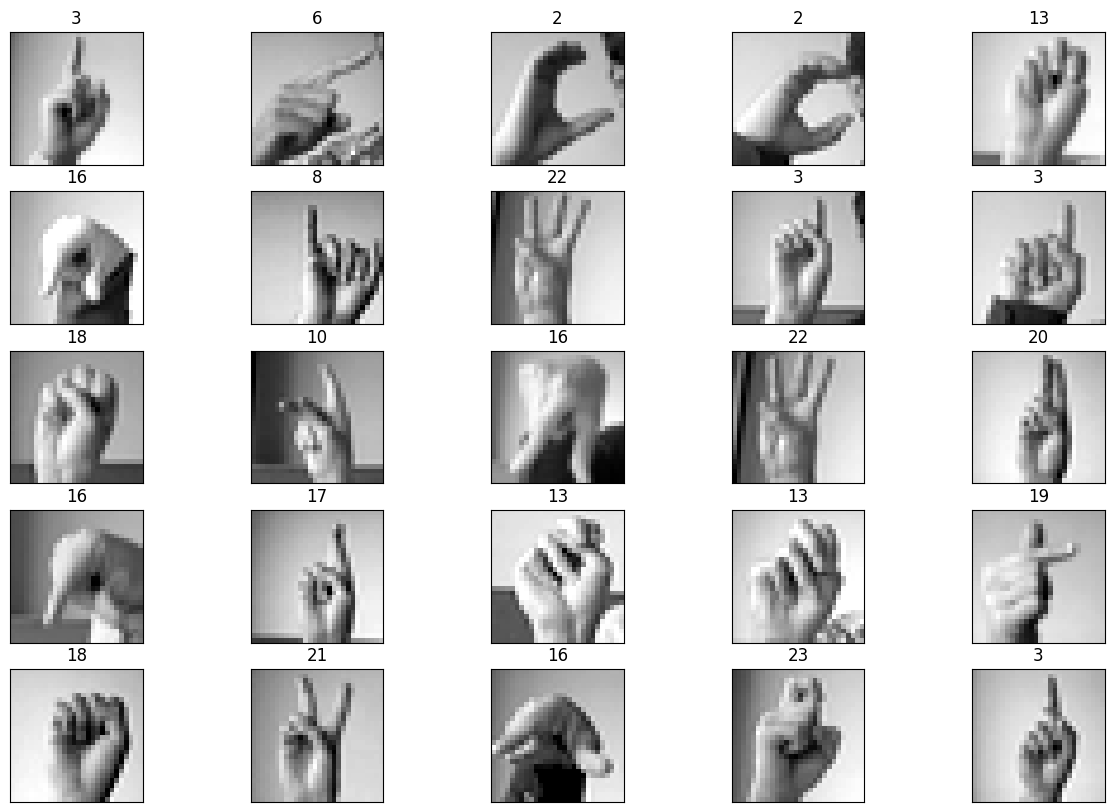

In [122]:
fig, ax = plt.subplots(5,5, figsize=(15,10), subplot_kw={'xticks': [], 'yticks': []})

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(y_train[i])

plt.show()

In [123]:
class Generator(Dataset): # use it for custom dataset
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [124]:
BATCH_SIZE = 32

In [125]:
training_data = Generator(x_train, y_train)
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

In [126]:
test_data = Generator(x_test, y_test)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [127]:
NUM_CLASSES = 10
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
DEVICE = 'cuda'

Feature batch shape: torch.Size([32, 28, 28, 1])
Labels batch shape: torch.Size([32])


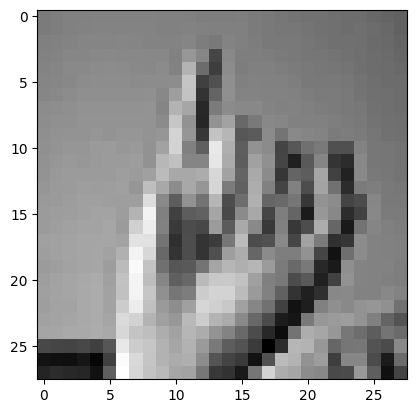

Label: 8


In [128]:
data, label = next(iter(train_dataloader))
print(f"Feature batch shape: {data.size()}")
print(f"Labels batch shape: {label.size()}")

# Plot
img = data[0].squeeze()
label = label[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Building model
Initially I built my model here. However, because I need to import model initialization in infer.py, so I need to move this to a different file (model_building.py)

In [129]:
# import math
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.nn import init
# import torch

# class SeparableConv2d(nn.Module):
#     def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
#         super(SeparableConv2d,self).__init__()

#         self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
#         self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)

#     def forward(self,x):
#         x = self.conv1(x)
#         x = self.pointwise(x)
#         return x


# class Block(nn.Module):
#     def __init__(self,in_filters,out_filters,reps,strides=1,start_with_relu=True,grow_first=True):
#         super(Block, self).__init__()

#         if out_filters != in_filters or strides!=1:
#             self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
#             self.skipbn = nn.BatchNorm2d(out_filters)
#         else:
#             self.skip=None

#         self.relu = nn.ReLU(inplace=True)
#         rep=[]

#         filters=in_filters
#         if grow_first:
#             rep.append(self.relu)
#             rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
#             rep.append(nn.BatchNorm2d(out_filters))
#             filters = out_filters

#         for i in range(reps-1):
#             rep.append(self.relu)
#             rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
#             rep.append(nn.BatchNorm2d(filters))

#         if not grow_first:
#             rep.append(self.relu)
#             rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
#             rep.append(nn.BatchNorm2d(out_filters))

#         if not start_with_relu:
#             rep = rep[1:]
#         else:
#             rep[0] = nn.ReLU(inplace=False)

#         if strides != 1:
#             rep.append(nn.MaxPool2d(3,strides,1))
#         self.rep = nn.Sequential(*rep)

#     def forward(self,inp):
#         x = self.rep(inp)

#         if self.skip is not None:
#             skip = self.skip(inp)
#             skip = self.skipbn(skip)
#         else:
#             skip = inp

#         x+=skip
#         return x

# class Xception(nn.Module):
#     def __init__(self, num_classes=1000, dropout_rate=0.3):
#         super(Xception, self).__init__()

#         self.num_classes = num_classes

#         self.conv1 = nn.Conv2d(1, 32, 3,2, 0, bias=False)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.relu = nn.ReLU(inplace=True)

#         self.conv2 = nn.Conv2d(32,64,3,bias=False)
#         self.bn2 = nn.BatchNorm2d(64)

#         self.dropout = nn.Dropout(dropout_rate)

#         self.block1 = Block(64,128,2,2,start_with_relu=False,grow_first=True)
#         self.block2 = Block(128,256,2,2,start_with_relu=True,grow_first=True)
#         self.block3 = Block(256,728,2,2,start_with_relu=True,grow_first=True)

#         self.block4 = Block(728,728,3,1,start_with_relu=True,grow_first=True)
#         self.block5 = Block(728,728,3,1,start_with_relu=True,grow_first=True)
#         self.block6 = Block(728,728,3,1,start_with_relu=True,grow_first=True)
#         self.block7 = Block(728,728,3,1,start_with_relu=True,grow_first=True)

#         self.block8 = Block(728,728,3,1,start_with_relu=True,grow_first=True)
#         self.block9 = Block(728,728,3,1,start_with_relu=True,grow_first=True)
#         self.block10 = Block(728,728,3,1,start_with_relu=True,grow_first=True)
#         self.block11 = Block(728,728,3,1,start_with_relu=True,grow_first=True)

#         self.block12=Block(728,1024,2,2,start_with_relu=True,grow_first=False)

#         self.conv3 = SeparableConv2d(1024,1536,3,1,1)
#         self.bn3 = nn.BatchNorm2d(1536)

#         self.conv4 = SeparableConv2d(1536,2048,3,1,1)
#         self.bn4 = nn.BatchNorm2d(2048)

#         self.fc = nn.Linear(2048, num_classes)

#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
#                 m.weight.data.normal_(0, math.sqrt(2. / n))
#             elif isinstance(m, nn.BatchNorm2d):
#                 m.weight.data.fill_(1)
#                 m.bias.data.zero_()

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)

#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.relu(x)

#         x = self.block1(x)
#         x = self.block2(x)
#         x = self.block3(x)
#         x = self.block4(x)
#         x = self.block5(x)
#         x = self.block6(x)
#         x = self.block7(x)
#         x = self.block8(x)
#         x = self.block9(x)
#         x = self.block10(x)
#         x = self.block11(x)
#         x = self.block12(x)

#         x = self.conv3(x)
#         x = self.bn3(x)
#         x = self.relu(x)

#         x = self.conv4(x)
#         x = self.bn4(x)
#         x = self.relu(x)

#         x = F.adaptive_avg_pool2d(x, (1, 1))
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)

#         output = F.log_softmax(x, dim=1)
#         return output


In [130]:
from model_building import Xception
model = Xception().to(DEVICE)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 13, 13]             288
       BatchNorm2d-2           [-1, 32, 13, 13]              64
              ReLU-3           [-1, 32, 13, 13]               0
            Conv2d-4           [-1, 64, 11, 11]          18,432
       BatchNorm2d-5           [-1, 64, 11, 11]             128
              ReLU-6           [-1, 64, 11, 11]               0
            Conv2d-7           [-1, 64, 11, 11]             576
            Conv2d-8          [-1, 128, 11, 11]           8,192
   SeparableConv2d-9          [-1, 128, 11, 11]               0
      BatchNorm2d-10          [-1, 128, 11, 11]             256
             ReLU-11          [-1, 128, 11, 11]               0
             ReLU-12          [-1, 128, 11, 11]               0
           Conv2d-13          [-1, 128, 11, 11]           1,152
           Conv2d-14          [-1, 128,

In [131]:
CHECKPOINT_PATH = 'finalXception.pth'

In [132]:
PROJECT = "Xception-mnist"
RESUME = "allow"
WANDB_KEY = "5fc240727579e51a800c26f42ecc1d0667822eb7"

In [133]:
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

In [134]:
wandb.init(
    project=PROJECT,
    resume=RESUME,
    config={
        "learning_rate": LEARNING_RATE,
        "epochs": NUM_EPOCHS,
        "batch_size": BATCH_SIZE,
    },
)
wandb.watch(model)

epoch,▁█
test_accuracy,▁█
test_loss,█▁
train_accuracy,▁█
train_loss,█▁
epoch,2
test_accuracy,0.30675
test_loss,5.21666
train_accuracy,0.26673
train_loss,5.30801


In [135]:
best_val_loss = 999

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = time.time()
    model.train() # Turn on train mode for gradient updates
    train_loss = 0
    train_accuracy = 0
    for data, target in train_dataloader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        data = data.permute(0, 3, 1, 2)
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        # Update metrics
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        train_accuracy += pred.eq(target.view_as(pred)).sum().item()
    scheduler.step()
    train_loss /= len(train_dataloader.dataset)
    train_accuracy /= len(train_dataloader.dataset)
    time_taken = time.time() - start_time

    model.eval() # Turn on train mode to disable gradient updates
    test_loss = 0
    test_accuracy = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            data = data.permute(0, 3, 1, 2)
            output = model(data)
            loss = loss_fn(output, target)
            # Update metrics
            test_loss += loss
            pred = output.argmax(dim = 1, keepdim = True)
            test_accuracy += pred.eq(target.view_as(pred)).sum().item()
        scheduler.step()
    test_loss /= len(test_dataloader.dataset)
    test_accuracy /= len(test_dataloader.dataset)

    # Log metrics
    print(
        f"Epoch {epoch}: Train Loss: {train_loss:.4f} | \
        Train Accuracy: {train_accuracy:.4f} | \
        Test Loss: {test_loss:.4f} | \
        Test Accuracy: {test_accuracy:.4f} | \
        Time taken: {time_taken:.4f}"
    )
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        torch.save(model.state_dict(), CHECKPOINT_PATH)
        print("New best checkpoint saved!")

    # Log results to WandB
    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy,
    })

wandb.finish()

Epoch 1: Train Loss: 0.3540 |         Train Accuracy: 0.8931 |         Test Loss: 0.6168 |         Test Accuracy: 0.8593 |         Time taken: 26.8780
New best checkpoint saved!
Epoch 2: Train Loss: 0.0152 |         Train Accuracy: 0.9956 |         Test Loss: 0.3216 |         Test Accuracy: 0.9184 |         Time taken: 26.1471
New best checkpoint saved!
Epoch 3: Train Loss: 0.0033 |         Train Accuracy: 0.9992 |         Test Loss: 0.1761 |         Test Accuracy: 0.9598 |         Time taken: 26.1954
New best checkpoint saved!
Epoch 4: Train Loss: 0.0006 |         Train Accuracy: 0.9999 |         Test Loss: 0.1710 |         Test Accuracy: 0.9551 |         Time taken: 26.1337
New best checkpoint saved!
Epoch 5: Train Loss: 0.0002 |         Train Accuracy: 1.0000 |         Test Loss: 0.1671 |         Test Accuracy: 0.9536 |         Time taken: 26.3252
New best checkpoint saved!
Epoch 6: Train Loss: 0.0001 |         Train Accuracy: 1.0000 |         Test Loss: 0.1560 |         Test Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁▅███▇██████████████
test_loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁███████████████████
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,0.95733
test_loss,0.15807
train_accuracy,1
train_loss,4e-05


# Infer.py (redundant)
This part is redundant. However, if the infer.py does not work, then please try this instead. Thank you!

In [136]:
# model.load_state_dict(torch.load(CHECKPOINT_PATH))
# model.eval()

Xception(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    

In [137]:
# data, target = next(iter(test_dataloader))
# test_idx = random.choice(range(len(data)))
# data = data[test_idx]
# target = target[test_idx]

Predict Number :  13


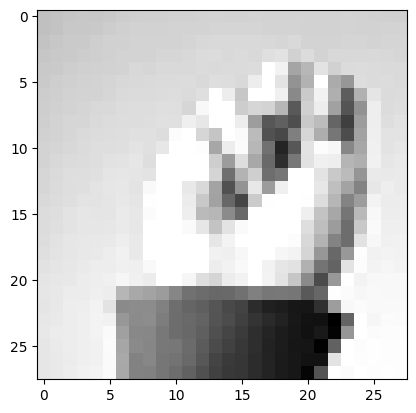

In [138]:
# def plot(data, model):
#     data = torch.unsqueeze(data, dim=0)
#     data = data.to(DEVICE)
#     data = data.permute(0, 3, 1, 2)
#     output = model(data)
#     pred = output.argmax(dim=1, keepdim=True)
#     print("Predict Number : ", pred[0][0].detach().cpu().numpy())
#     plt.imshow(data[0][0].detach().cpu().numpy(), cmap='gray')
#     plt.show()

# plot(data, model)